<h1 style="text-align:center;">
<img src = "Webp.net-resizeimage.png"/>

<h3 style="text-align: center;"> By Team White Swan </h3>


### Table Of Contents:
* [General Properties](#1)
* [Exploratory Data Analysis (EDA)](#2)
* [Train-test-split](#3)
* [Feature Engineering](#4)
* [Modelling](#5)
* [Predict Churn Probabilities](#6)




In [12]:
## Importing Libraries
 #For Handling and Visualising Data
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

 # For Modelling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier # Decison Tree Model
from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.preprocessing import MinMaxScaler

 # For measuring our models performance
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

In [14]:
## Read in Data
df = pd.read_csv('Swan_Project_Data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Swan_Project_Data.csv'

## **1** General properties <a class="anchor" id="1"></a>

In [ ]:
## Check first few rows
 # Set option to display all columns
pd.set_option('display.max_columns', None)
df.head(3)

In [ ]:
## Check shape
df.shape

In [ ]:
## Check columns
df.columns

In [ ]:
## Check data types
df.dtypes

In [ ]:
## Check Nulls

def null_vals(dataframe):
    '''Function to show both number of nulls and the percentage of nulls in the whole column'''
    null_vals = dataframe.isnull().sum() # How many nulls in each column
    total_cnt = len(dataframe) # Total entries in the dataframe
    null_vals = pd.DataFrame(null_vals,columns=['null']) # Put the number of nulls in a single dataframe
    null_vals['percent'] = round((null_vals['null']/total_cnt)*100,3) # Round how many nulls are there, as %, of the df
    
    return null_vals.sort_values('percent', ascending=False) #Return the number and percentage of missing values, order by percentage descending

null_vals(df) #Display the table

It can seen that there are 5174 nulls in Churn Reason. These are all the customers who have not churned.

## **2** EDA <a class="anchor" id="2"></a>

### **2.1** Summary Statistics

First, check the summary statistics to get a feel of the dataset.

In [ ]:
# Check summary statistics
df.describe()

## **2.2** Graphs

Have a look at the correlation within the numeric columns

In [24]:
# Look at correlation matrix as a heatmap
cm = df.corr(numeric_only=True)

plt.figure(figsize = (8, 5))
sns.heatmap(cm,
            cmap = 'RdBu_r',
            annot=True,
            fmt = '.1',
            mask = np.triu(cm))

plt.show()

NameError: name 'df' is not defined

In [ ]:
# Have a look at the pairplot
sns.pairplot(df)

>The pairplot doesn't reveal many correlations. Our Target is _'Churn Value'_ which has discrete classes so this plot isn't very revealing

\
**Is churn related to amount of monthly charges and duration of services?**

NameError: name 'df' is not defined

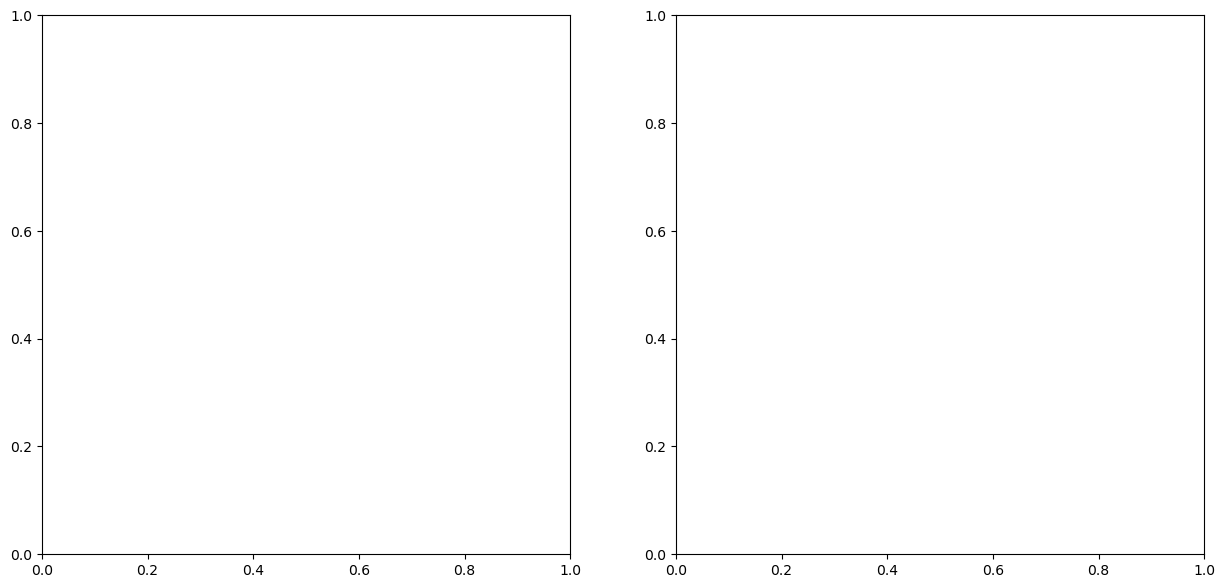

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharey=False)

#Is churn related to amount of monthly charges?
sns.histplot(data=df, x='Monthly Charges', 
            hue='Churn Value', 
            #kind='hist', 
            kde=True, 
            palette='viridis', 
            bins=20,
            ax=axes[0])
axes[0].set_title('Distribution Plot of Monthly Charges and Churn')
axes[0].set_xlabel('Monthly Charges')
axes[0].set_ylabel('Frequency')
axes[0].legend(['Churned', 'Not Churned'], title='Churn Status')

#Is churn related to duration of service?
sns.histplot(data=df, x='Tenure Months', 
            hue='Churn Value', 
            #kind='hist', 
            kde=True, 
            palette='viridis', 
            bins=20,
            ax=axes[1])
axes[1].set_title('Distribution Plot of Tenure Months and Churn')
axes[1].set_xlabel('Duration')
axes[1].set_ylabel('Frequency')
axes[1].legend(['Churned', ' Not Churned'], title='Churn Status')


plt.tight_layout()
plt.show()

> There is a higher percentage of churners in the 70 - 100 dollar range  
> The longer they stay with the company, the less they churn


\
**What does the churn look like in each contract-type?**

In [33]:
contract_totals = df['Contract'].value_counts().reset_index()
contract_totals

,Contract,count
0,Month-to-month,3875
1,Two year,1695
2,One year,1473


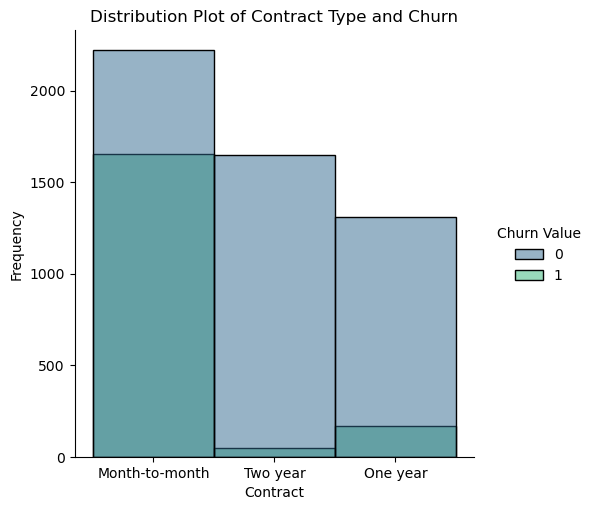

In [34]:
sns.displot(data=df, x='Contract', 
            hue='Churn Value', 
            kind='hist',  
            palette='viridis', 
            bins=20)
plt.title('Distribution Plot of Contract Type and Churn')
plt.xlabel('Contract')
plt.ylabel('Frequency')
plt.show()

> We see that people with a Month-to-Month Contract are more likely to churn

\
**What does the churn rate look like in each payment type?**

In [37]:
payment_totals = df['Payment Method'].value_counts().reset_index()
payment_totals

,Payment Method,count
0,Electronic check,2365
1,Mailed check,1612
2,Bank transfer (automatic),1544
3,Credit card (automatic),1522


C:\Users\lenovo\AppData\Local\Temp\ipykernel_12968\2038200144.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payment_totals, x = 'Payment Method', y = 'count', palette = 'viridis')


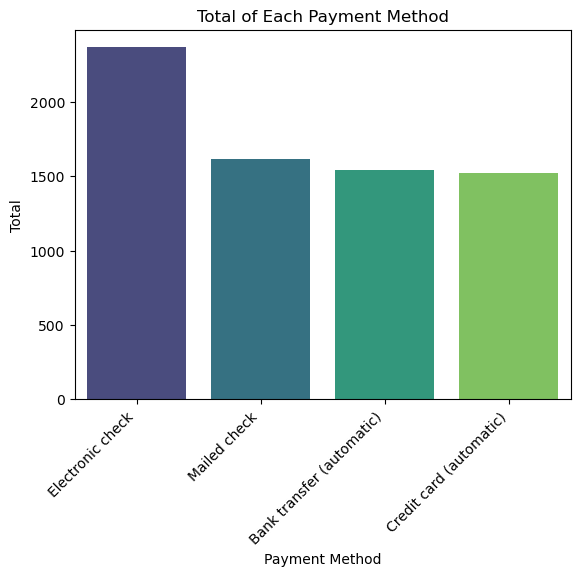

In [43]:
sns.barplot(data=payment_totals, x = 'Payment Method', y = 'count', palette = 'viridis')
plt.title('Total of Each Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total')
plt.xticks(rotation=45,
           horizontalalignment = 'right',
           fontweight = 'light',
           fontsize = 'medium'
          )
plt.show()

> We see that a lot more people with an electronic check have churned

\
**Do the different support types affect the churn?**

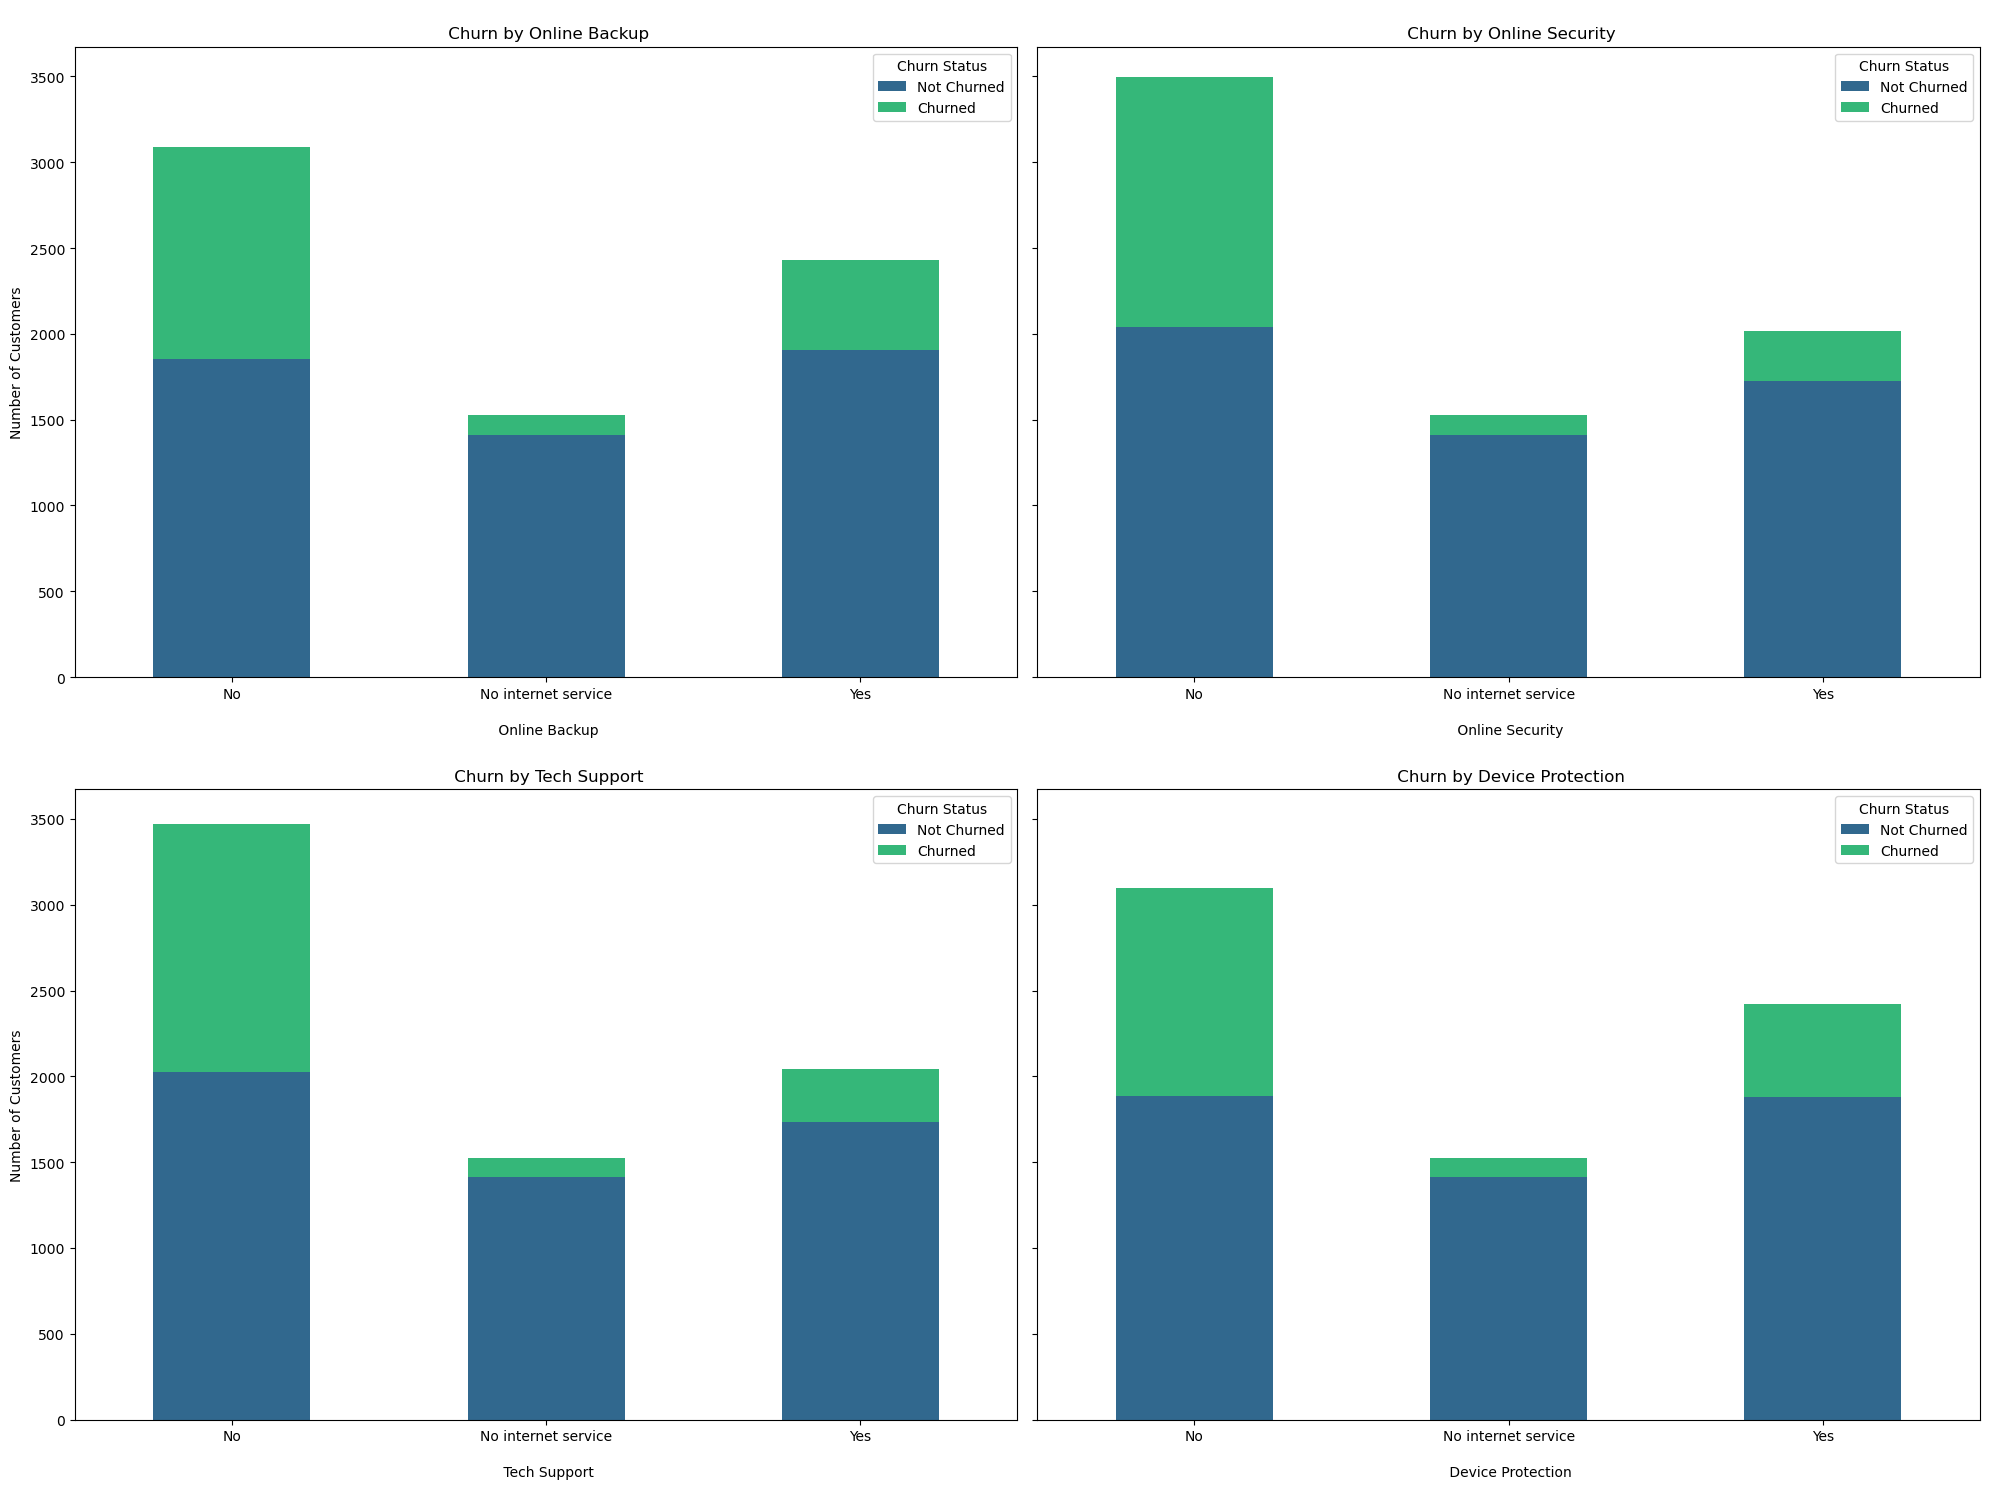

In [47]:
# Count churn and not churn for each category
churn_counts_backup = df.groupby(['Online Backup', 'Churn Value']).size().unstack(fill_value=0)
churn_counts_security = df.groupby(['Online Security', 'Churn Value']).size().unstack(fill_value=0)
churn_counts_tech_support = df.groupby(['Tech Support', 'Churn Value']).size().unstack(fill_value=0)
churn_counts_device_protection = df.groupby(['Device Protection', 'Churn Value']).size().unstack(fill_value=0)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15), sharey=True)

# Define viridis palette
colors = sns.color_palette('viridis',2)

# Plot for Online Backup
churn_counts_backup.plot(kind='bar', stacked=True, color=colors, ax=axes[0, 0])
axes[0, 0].set_title('\n Churn by Online Backup')
axes[0, 0].set_xlabel('\n Online Backup')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].legend(['Not Churned', 'Churned'], title='Churn Status')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0, ha='center')

# Plot for Online Security
churn_counts_security.plot(kind='bar', stacked=True, color=colors, ax=axes[0, 1])
axes[0, 1].set_title('\n Churn by Online Security')
axes[0, 1].set_xlabel('\n Online Security')
axes[0, 1].legend(['Not Churned', 'Churned'], title='Churn Status')
axes[0, 1].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0, ha='center')

# Plot for Tech Support
churn_counts_tech_support.plot(kind='bar', stacked=True, color=colors, ax=axes[1, 0])
axes[1, 0].set_title('\n Churn by Tech Support')
axes[1, 0].set_xlabel('\n Tech Support')
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].legend(['Not Churned', 'Churned'], title='Churn Status')
axes[1, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0, ha='center')

# Plot for Device Protection
churn_counts_device_protection.plot(kind='bar', stacked=True, color=colors, ax=axes[1, 1])
axes[1, 1].set_title('\n Churn by Device Protection')
axes[1, 1].set_xlabel('\n Device Protection')
axes[1, 1].legend(['Not Churned', 'Churned'], title='Churn Status')
axes[1, 1].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0, ha='center')

plt.tight_layout()
plt.show()


> We see that people without the extra support services have churned more

\
**What are the Top Reasons for Churning?**

C:\Users\lenovo\AppData\Local\Temp\ipykernel_12968\4106336346.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_df, y='Churn Reason', palette='viridis_r', order = churn_reason_counts.index)


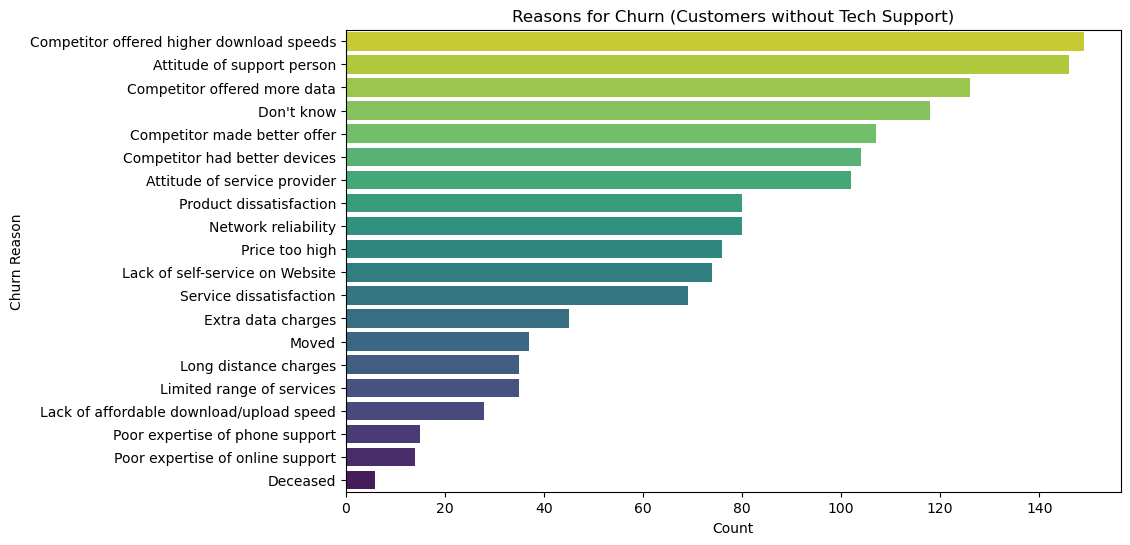

In [51]:
filtered_df = df[(df['Tech Support'] == 'No') & (df['Churn Value'] == 1)]
churn_reason_counts = filtered_df['Churn Reason'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df, y='Churn Reason', palette='viridis_r', order = churn_reason_counts.index)
plt.title('Reasons for Churn (Customers without Tech Support)')
plt.xlabel('Count')
plt.ylabel('Churn Reason')
plt.show()

> We noticed that the competitor offering higher speeds and the attitude of support person are among the top reasons for customers churning. This remained true when we grouped the data by different parameters too.

## **3** Train-test-split <a class="anchor" id="3"></a>

In [259]:
# Seperating Features and Target
X = df.drop('Churn Value', axis = 1)
y = df['Churn Value']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, # Feature
                                                    y, # Target
                                                    test_size = 0.2, 
                                                    random_state = 42)

## **4** Feature Engineering <a class="anchor" id="4"></a>

In [261]:
X_train.head(3)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Reason
2142,9571-EDEBV,1,United States,California,San Diego,92119,"32.802959, -117.027095",32.802959,-117.027095,Male,No,Yes,No,71,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),98.65,6962.85,No,NaN
1623,7562-GSUHK,1,United States,California,Jamestown,95327,"37.84771, -120.486589",37.847710,-120.486589,Female,No,No,No,16,Yes,No,Fiber optic,No,Yes,Yes,No,No,Yes,Month-to-month,Yes,Credit card (automatic),93.20,1573.7,Yes,Competitor made better offer
6074,2325-WINES,1,United States,California,Littlerock,93543,"34.505273, -117.955054",34.505273,-117.955054,Female,No,No,No,32,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),104.05,3416.85,No,NaN


In [262]:
## Some Columns have Yes's and No's 
 # Check Thats all they have:
yn_cols = ['Senior Citizen','Partner','Dependents','Phone Service','Multiple Lines',
               'Online Security','Online Backup','Device Protection','Tech Support',
               'Streaming TV','Streaming Movies','Paperless Billing']
for col in yn_cols:
    print(f'{col}', 'has unique values:', X_train[f'{col}'].unique())

Senior Citizen has unique values: ['No' 'Yes']
Partner has unique values: ['Yes' 'No']
Dependents has unique values: ['No' 'Yes']
Phone Service has unique values: ['Yes' 'No']
Multiple Lines has unique values: ['Yes' 'No' 'No phone service']
Online Security has unique values: ['No' 'No internet service' 'Yes']
Online Backup has unique values: ['No' 'Yes' 'No internet service']
Device Protection has unique values: ['Yes' 'No internet service' 'No']
Tech Support has unique values: ['No' 'No internet service' 'Yes']
Streaming TV has unique values: ['Yes' 'No' 'No internet service']
Streaming Movies has unique values: ['Yes' 'No internet service' 'No']
Paperless Billing has unique values: ['Yes' 'No']


><b>Notes</b>:
-  _'No Internet Service'_ or _'No Phone Service'_ means that they don't have these features so we       can just treat them as _'No'_   
-  We also realised that there were some hidden **nulls** in the _'Total Charges'_ column in the         form of an empty string. These aligned with the customers that had _'Tenure Months'_ equal to 0,       i.e they have just joined and hence not paid yet. We will set these equal to 0.  
* Drop Columns:  
    - <i>'CustomerID', 'City', 'Zip Code','Lat Long', 'Latitude', 'Longitude' </i>:  They are unique            identifiers  
    - <i>'Count', 'Country', 'State'</i>:  They contain the same value for all customers  
    - <i>'Churn Label'<\i>:  We have _'Churn Value'_   
    - <i>'Churn Reason'</i>: It is unnecassary since we only have them for the customers who have churned.



In [266]:
def feature_eng(dataframe):
    '''Function with all our feature engineering'''
    
    # Make a copy of dataframe
    df = dataframe.copy()
    
    ##### Mapping columns #######
    # list of columns with yes's and no's
    yn_cols = ['Senior Citizen','Partner','Dependents','Phone Service','Multiple Lines',
               'Online Security','Online Backup','Device Protection','Tech Support',
               'Streaming TV','Streaming Movies','Paperless Billing']
    # mapping the above columns
    for col in yn_cols:
        df[f'{col}'] = df[f'{col}'].map({'No':0, 'Yes':1, 'No phone service':0, 'No internet service':0, 
                                         0:0, 1:1})
        df[f'{col}'].astype(int) # Makes sure the column dtype is integer
    # mapping gender column
    df['Gender'] = df['Gender'].map({'Male':0, 'Female': 1})
    
    ###### Drop Columns #########
    df.drop(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
            'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Reason'], axis = 1, inplace = True)
    
    ###### OHE ###############
    df = pd.get_dummies(data = df, columns = ['Internet Service'], prefix='IS', drop_first=False, dtype = int)
    df = pd.get_dummies(data = df, columns = ['Contract'], prefix='Con', drop_first=False, dtype = int)
    df = pd.get_dummies(data = df, columns = ['Payment Method'], prefix='Pay', drop_first=False, dtype = int)
    

    ##### Target Columns - hidden nulls in diguise  #################
    df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

    # Fills nulls with zeros 
    df['Total Charges'] = df['Total Charges'].fillna(value = 0)
    
    return df

In [268]:
# Apply to X_train and X_test 
X_train_fe = feature_eng(X_train)
X_test_fe = feature_eng(X_test)

In [269]:
X_train_fe.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Monthly Charges,Total Charges,IS_DSL,IS_Fiber optic,IS_No,Con_Month-to-month,Con_One year,Con_Two year,Pay_Bank transfer (automatic),Pay_Credit card (automatic),Pay_Electronic check,Pay_Mailed check
2142,0,0,1,0,71,1,1,0,0,1,0,1,1,1,98.65,6962.85,0,1,0,0,1,0,0,1,0,0
1623,1,0,0,0,16,1,0,0,1,1,0,0,1,1,93.20,1573.70,0,1,0,1,0,0,0,1,0,0
6074,1,0,0,0,32,1,1,0,1,1,0,1,1,1,104.05,3416.85,0,1,0,0,1,0,0,1,0,0
1362,1,1,1,0,24,0,0,0,0,1,0,0,1,1,40.65,933.30,1,0,0,1,0,0,0,1,0,0
6754,1,0,1,1,20,1,0,0,0,0,0,0,0,0,20.05,406.05,0,0,1,1,0,0,0,0,0,1


### **4.2** Correlations
Have a look at the correlations on the feature engineered data

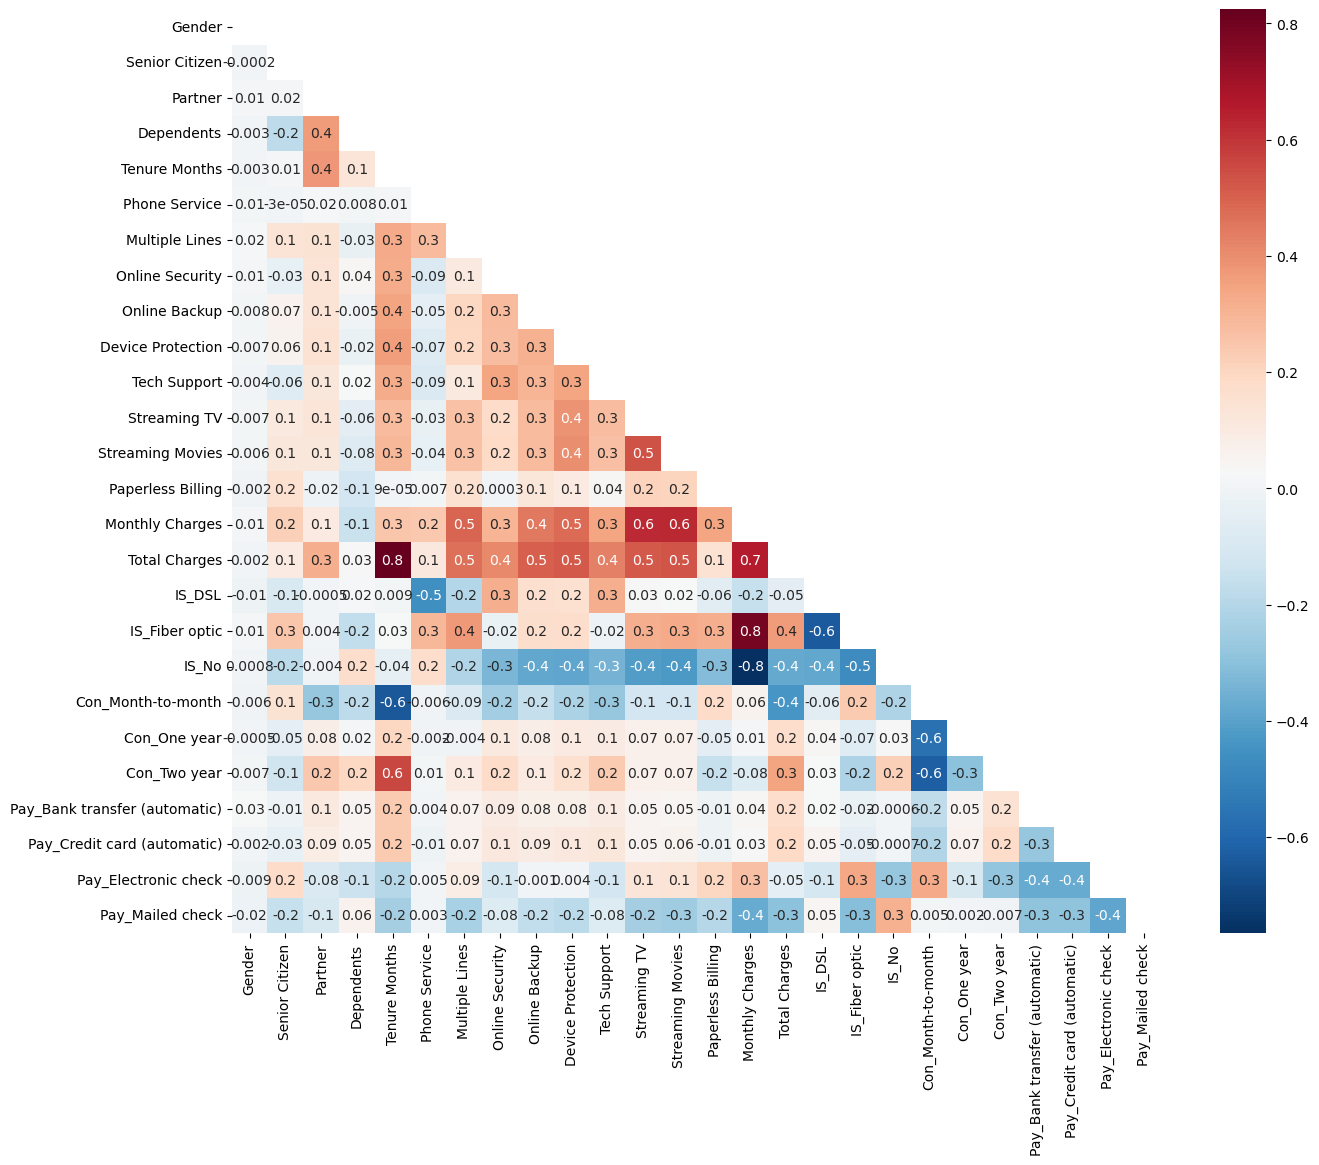

In [271]:
# Look at correlation matrix as a heatmap
cm = X_train_fe.corr(numeric_only=True)

plt.figure(figsize = (15, 12))
sns.heatmap(cm,
            cmap = 'RdBu_r',
            annot=True,
            fmt = '.1',
            mask = np.triu(cm))

plt.show()

## **5** Modelling <a class="anchor" id="5"></a>

In [275]:
## Function that shows metrics of our model
def apr(y_pred, y_real):
    """ Calculates accuracy, precision, recall
        Requires predicted value first, and then the real value
    """
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

### **5.1** Random Forest

In [280]:
# The Model
rf = RandomForestClassifier()

# Fit it!
rf.fit(X_train_fe, y_train)

RandomForestClassifier()

In [281]:
## Check respective cross validation scores 
rf_score = cross_val_score(rf, X_train_fe, y_train, cv=5)
rf_score

array([0.79680568, 0.80567879, 0.78438332, 0.7755102 , 0.80284192])

In [282]:
## Variance in the values above so run Grid Search to reduce overfitting
 # Step 1: Select parameters
rf_params = {'criterion': ['gini','entropy'], 
             'n_estimators': [200], 
             'max_depth': [6],
             'min_samples_split': [6],
             'min_samples_leaf': [8]
            }

 # Step 2: Create a grid search object
gs = GridSearchCV(rf, param_grid=rf_params, cv=10, verbose = 1) # k = 5

 # Step 3: Fit grid search on the training set
gs.fit(X_train_fe, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [6],
                         'min_samples_leaf': [8], 'min_samples_split': [6],
                         'n_estimators': [200]},
             verbose=1)

In [284]:
# Have a look at the Best Parameters
gs.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=6, min_samples_leaf=8,
                       min_samples_split=6, n_estimators=200)

In [288]:
# Save my best model as a random forest model
best_rf = gs.best_estimator_



#### Predict on Train

In [293]:
# I use the model to predict on X_train
y_pred_rf = best_rf.predict(X_train_fe)

In [294]:
# Check the metrics
apr_rf = apr(y_pred_rf, y_train)

Accuracy:0.8189563365282215
Precision:0.7140133460438512
Recall:0.5098706603131382
F1:0.5949166004765686


#### Predict on Test

In [296]:
# I use the model to predict on X_train
y_test_pred_rf = best_rf.predict(X_test_fe)

In [298]:
# Check the metrics
apr_test_rf = apr(y_test_pred_rf, y_test)

Accuracy:0.7970191625266146
Precision:0.7007042253521126
Recall:0.4975
F1:0.5818713450292398


### **5.2** Logistic Regression

In [301]:
## Scaling the data
scaler = MinMaxScaler()

# Scale the features
X_train_fe_s = scaler.fit_transform(X_train_fe)  # Fit on _train_ data and transform it
X_test_fe_s = scaler.transform(X_test_fe)  # Tranform the _test_ data

In [302]:
# Modelling and Fitting
lr = LogisticRegression(max_iter=1000, random_state=10)
lr.fit(X_train_fe_s, y_train)

LogisticRegression(max_iter=1000, random_state=10)

#### Predict on Train

In [305]:
# I use the model to predict on X_train
y_pred_lr = lr.predict(X_train_fe_s)

In [306]:
# Check the metrics
apr_lr = apr(y_pred_lr, y_train)

Accuracy:0.8154064607738729
Precision:0.6706443914081146
Recall:0.5738597685500341
F1:0.6184886280264125


#### Predict on Test

In [308]:
# I use the model to predict on X_train
y_test_pred_lr = lr.predict(X_test_fe_s)

In [309]:
# Check the metrics
apr_test_lr = apr(y_test_pred_lr, y_test)

Accuracy:0.8041163946061036
Precision:0.6834319526627219
Recall:0.5775
F1:0.6260162601626017


### Compare the Results from both Models

In [311]:
# Create Table to see all the Metrics for all the tests we ran:
am = {'': ['Accuracy', 'Precision', 'Recall', 'F1'],
               'rf_train': apr_rf,
               'rf_test': apr_test_rf,
               'lr_train': apr_lr,
               'lr_test':apr_test_lr}

all_metrics = pd.DataFrame(am).set_index('').transpose()
all_metrics

,Accuracy,Precision,Recall,F1
rf_train,0.818956,0.714013,0.509871,0.594917
rf_test,0.797019,0.700704,0.497500,0.581871
lr_train,0.815406,0.670644,0.573860,0.618489
lr_test,0.804116,0.683432,0.577500,0.626016


* We see that there is a **1.56%** difference in  the accuracy score for the RainForest Test whereas only a **1.13%** difference in the accuracy for the LogisticRegression Model. This means that the LogisticRegression model has less overfitting. 
* We also see that the LogisticRegression Model has a higher F1 score than the RainForest Model which means that it has a better balance between Precison and Recall.

As a result we have decided to go along with our **LogisticRegression Model** to predict how likely each customer is to churn.

## **6** Predict Churn Probabilities for the Entire Dataset <a class="anchor" id="6"></a>
Predict churn probabilities for the entire dataset and select customers at risk.
Identify the top 500 customers who are at risk of churning

In [148]:
# Feature Engineer and Scale all the data
X_fe = feature_eng(X)
X_fe_s = scaler.transform(X_fe)

In [150]:
# Predict churn probabilities for the entire dataset and add on to oridinal dataframe
df[['Stay Probability', 'Churn Probability']] = lr.predict_proba(X_fe_s)

In [151]:
# Have a look
df.head(3)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason,Stay Probability,Churn Probability
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer,0.663225,0.336775
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved,0.635164,0.364836
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved,0.502013,0.497987


In [152]:
## Make table with customers we still have and their probability of churning
non_churned_customers = df[df['Churn Value'] == 0][['CustomerID', 'Churn Probability']]

In [153]:
## Select top 500 customers at risk of churning
 # Sort by churn probability
 # Then select top 500
at_risk_customers = non_churned_customers.sort_values(by='Churn Probability', 
                                                      ascending=False).head(500)

In [155]:
# Have a look 
non_churned_customers.head(2)

,CustomerID,Churn Probability
1869,7590-VHVEG,0.689186
1870,5575-GNVDE,0.056292


In [158]:
# Have a look
at_risk_customers.head()

,CustomerID,Churn Probability
2567,6630-UJZMY,0.841530
3732,4927-WWOOZ,0.839120
4624,3489-HHPFY,0.838032
4198,5150-ITWWB,0.833709
4341,2545-EBUPK,0.808790


In [196]:
# All the customers without the top 500
remaining_customers = non_churned_customers.drop(at_risk_customers.index)

In [2]:
## Take a look
remaining_customers.head()

NameError: name 'remaining_customers' is not defined

Converting these tables to spreadsheets to hand to the client:

In [199]:
# Top 500 customer to whom you should send the mails to
at_risk_customers.to_csv('at_risk_customers.csv', index = False)

In [201]:
# Remaining customers and their churn risk
remaining_customers.to_csv('remaining_customers.csv', index = False)